In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import confusion_matrix
main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\BreastUltrasound\\Dataset_BUSI_with_GT"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    files = os.listdir(main_path+"\\"+direct)
    if direct == "normal":
        code = 0
    #elif direct == "normal":
    #    code = 1
    else:
        code = 1
    for file in files:
        if not file.endswith("_mask.png"):
            img = cv2.imread(main_path+"\\"+direct+"\\"+file)
            img = cv2.resize(img, (400,400))
            labels.append(code)
            images.append(img)


In [7]:
images = np.asarray(images)
labels = np.asarray(labels)
images.shape

(798, 400, 400, 3)

In [8]:
data = images/255.0

In [9]:
X_train,X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True)


In [10]:
model = Sequential([
    Conv2D(32, 3, input_shape=(400,400,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    #GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 398, 398, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 197, 197, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,883,489 (72.03 MB)

 Trainable params: 18,883,361 (72.03 MB)

 Non-trainable params: 128 (512.00 B)

In [12]:
model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5), loss=tf.keras.losses.BinaryCrossentropy, metrics=['accuracy']) 

In [13]:
model.fit(X_train, y_train, batch_size=20, epochs=1, validation_data=(X_test, y_test))

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7507 - loss: 1.1517 - val_accuracy: 0.1625 - val_loss: 2.0610
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9743 - loss: 0.0958 - val_accuracy: 0.1625 - val_loss: 4.3667
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9882 - loss: 0.0371 - val_accuracy: 0.1625 - val_loss: 6.2171
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.1625 - val_loss: 7.0390
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.1625 - val_loss: 7.9350
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.1625 - val_loss: 8.4063
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.1625 - val_loss: 8.3445
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.1625 - val_loss:

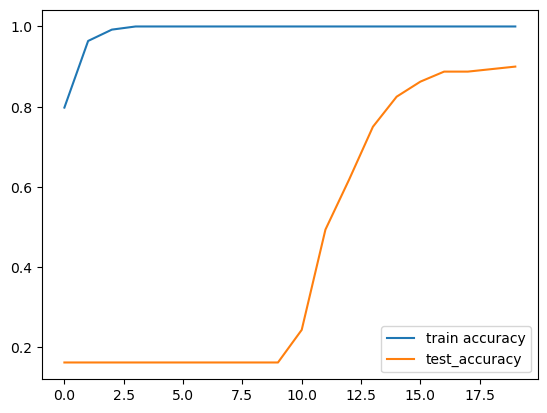

In [14]:
plt.plot(model.history.history['accuracy'], label='train accuracy')
plt.plot(model.history.history['val_accuracy'], label='test_accuracy')
plt.legend()
plt.show()

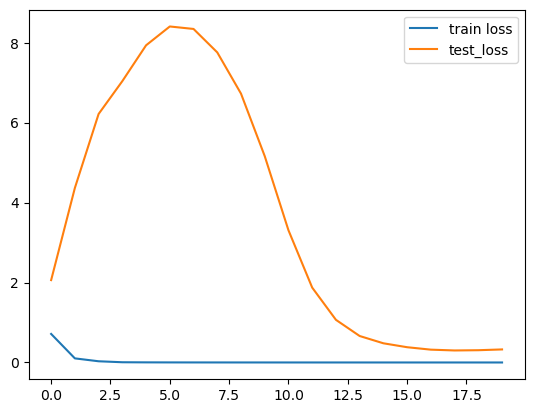

In [15]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

In [18]:
path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\BreastUltrasound\\Dataset_BUSI_with_GT\\benign\\benign (14).png"
img = cv2.imread(path)
img = img/255
img = cv2.resize(img, (400,400))
img = np.asarray([img])
ans = model.predict(img)[0][0]
ans
if ans > 0.5:
    print("Lesion Present")
else:
    print("No obvious Lesion ")
print(ans)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Lesion Present
0.9712739


In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

In [1]:
from openslide import open_slide

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=1, input_shape=[3])
])

C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=4, activation='relu', input_shape=[2]),
    layers.Dense(units=3, activation='relu'),
    layers.Dense(units=1),
])

C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
w = model.weights

In [5]:
w

[<KerasVariable shape=(2, 4), dtype=float32, path=sequential_1/dense_1/kernel>,
 <KerasVariable shape=(4,), dtype=float32, path=sequential_1/dense_1/bias>,
 <KerasVariable shape=(4, 3), dtype=float32, path=sequential_1/dense_2/kernel>,
 <KerasVariable shape=(3,), dtype=float32, path=sequential_1/dense_2/bias>,
 <KerasVariable shape=(3, 1), dtype=float32, path=sequential_1/dense_3/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_1/dense_3/bias>]